This notebook creates a linear regression model to predict the price of diamonds. Categorical features are converted to ordinal values.

# Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## sklearn

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn import feature_selection

## other

In [3]:
import scipy.stats as stats

# Custom Functions

## Model Evaluation Function
Function to create evaluation plots given test input

In [4]:
def lr_eval(model, X, y):
    # output r squared score for model
    print('R-squared:', model.score(X, y))
    
    # cacluate model residuals
    predictions = model.predict(X)
    residuals = y - predictions
    
    # evaluation plots
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(7, 20))
    ax1.scatter(y, predictions)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Actual Value')
    ax1.set_ylabel('Predicted Value')
    ax2.scatter(predictions, residuals)
    ax2.set_title('Residual Plot')
    ax2.set_xlabel('Predicted Value')
    ax2.set_ylabel('Residual')
    stats.probplot(residuals, dist='norm', plot=plt);

# Data

In [5]:
filename = 'data/diamonds.csv'

In [6]:
n = sum(1 for line in open(filename)) - 1
s = 2000
random.seed(5)
skip = sorted(random.sample(range(1, n+1), n-s))
df = pd.read_csv(filename, skiprows=skip, index_col=0)

In [7]:
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
49,0.25,Very Good,E,VS2,63.3,60.0,404,4.00,4.03,2.54
66,0.28,Ideal,G,VVS2,61.4,56.0,553,4.19,4.22,2.58
79,0.26,Very Good,D,VVS2,62.8,60.0,554,4.01,4.05,2.53
120,0.80,Ideal,F,SI2,59.9,59.0,2762,6.01,6.07,3.62
188,0.71,Premium,F,VS2,62.1,58.0,2777,5.67,5.70,3.53


In [8]:
X_num = df.iloc[:, [0, 4, 5, 6, 7, 8]].copy()

In [9]:
y = X_num.pop('price')
y.head()

49      404
66      553
79      554
120    2762
188    2777
Name: price, dtype: int64

In [10]:
X_num.head()

,carat,depth,table,x,y
49,0.25,63.3,60.0,4.00,4.03
66,0.28,61.4,56.0,4.19,4.22
79,0.26,62.8,60.0,4.01,4.05
120,0.80,59.9,59.0,6.01,6.07
188,0.71,62.1,58.0,5.67,5.70


In [11]:
X_cat = df.iloc[:, [1, 2, 3]].copy()
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


## Column Definitions

carat (num): weight in carats (1 carat = 200 mg) (0.2--5.01)

cut (cat): quality of the cut (Fair, Good, Very Good, Premium, Ideal)

color (cat): diamond color (J (worst) -- D (best))

clarity (cat): how obvious inclusions are within the diamond (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

depth (num): height of diamond, measured from the culet (bottom tip) to the table (top), divided by its average girdle (widest dimension) diameter = z / mean(x, y) (43--79)

table (num): width of diamond's table (top) expressed as a percentage of its average diameter

price (num): price in US dollars (326--18,823)

x (num): length in mm (0--10.74)

y (num): width in mm (0--58.9)

z (num): depth in mm (0--31.8)

# Diamond Dimensions
<img src = 'data/diamondanatomyimproved.jpg'>

## EDA

### Data Distributions

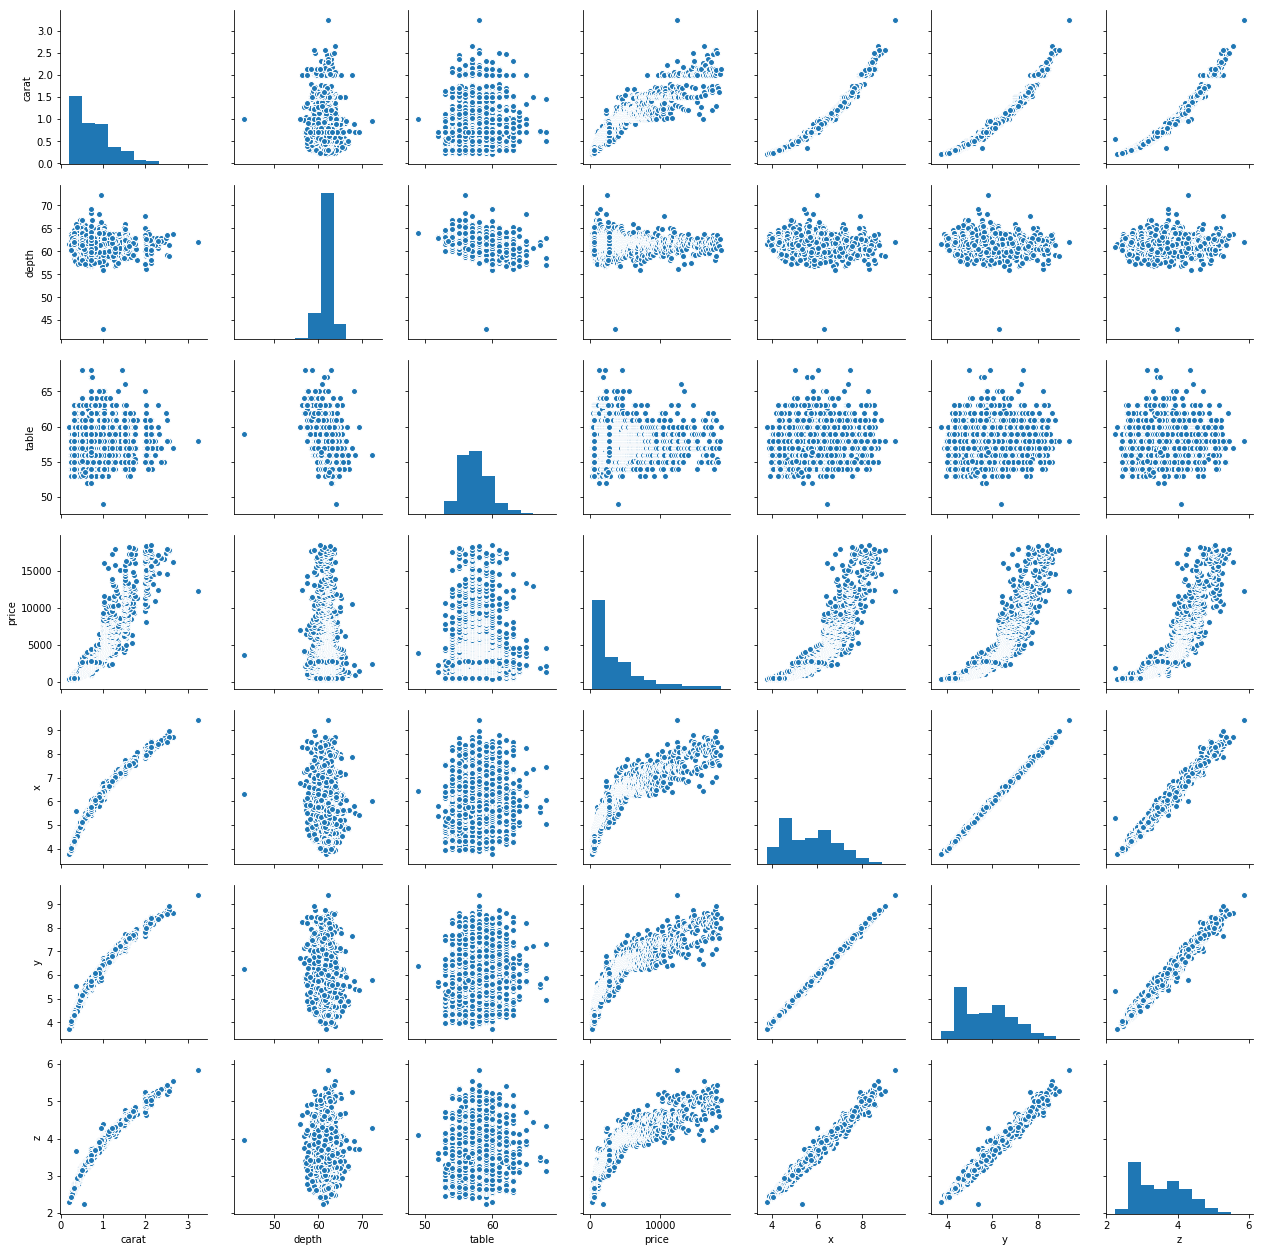

In [12]:
sns.pairplot(df);

## Variable Distributions

### Carat Distribution

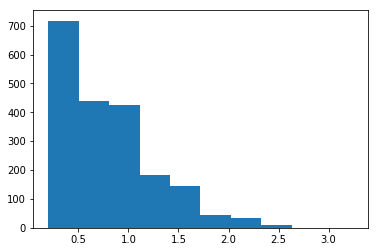

In [13]:
plt.hist(df['carat']);

### Price Distribution

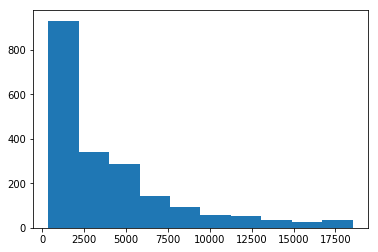

In [14]:
plt.hist(df['price']);

## Feature-Target Plots

### Carat vs Price

Text(0,0.5,'Price ($)')

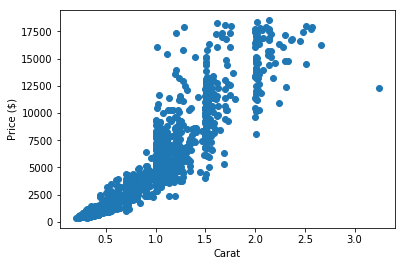

In [15]:
plt.scatter(df['carat'], df['price'])
plt.xlabel('Carat')
plt.ylabel('Price ($)')

# Pre-processing

## Categorical Data

### One-Hot Encoding
Encode categorical features as sparse matrix of categorical labels.

In [16]:
X_cat_enc = pd.get_dummies(X_cat)
X_cat_enc.head()

,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
49,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
66,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
79,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
120,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
188,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


### Oridnal
Encode categorical features as ordinal rank for each category.

In [17]:
X_cat_ord = X_cat.copy()

In [18]:
cut_ord = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_ord = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_ord = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
ord_list = [cut_ord, color_ord, clarity_ord]

In [19]:
# replace string feature labels with ordinal values
for i, column in enumerate(X_cat_ord.columns):
    
    # create label dictionary for each categorical feature
    label_dict = {}
    for j, label in enumerate(ord_list[i]):
        # map each label to ordinal value
        label_dict[label] = j
    
    # replace feature labels with ordinal values
    X_cat_ord[column] = X_cat_ord[column].map(label_dict)

In [20]:
X_cat.head()

,cut,color,clarity
49,Very Good,E,VS2
66,Ideal,G,VVS2
79,Very Good,D,VVS2
120,Ideal,F,SI2
188,Premium,F,VS2


In [21]:
X_cat_ord.head()

,cut,color,clarity
49,2,5,3
66,4,3,5
79,2,6,5
120,4,4,1
188,3,4,3


## Combine Numerical and Categorical Features

In [22]:
X = pd.concat([X_num, X_cat_ord], axis=1)
X.head()

,carat,depth,table,x,y,cut,color,clarity
49,0.25,63.3,60.0,4.00,4.03,2,5,3
66,0.28,61.4,56.0,4.19,4.22,4,3,5
79,0.26,62.8,60.0,4.01,4.05,2,6,5
120,0.80,59.9,59.0,6.01,6.07,4,4,1
188,0.71,62.1,58.0,5.67,5.70,3,4,3


## Test/Train Split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modeling

In [24]:
lr = LinearRegression()

## Initial Model

In [25]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

0.9195790119382556

## Cross-validation

In [26]:
np.mean(cross_val_score(lr, X_train, y_train, cv=10))

0.9161396278390106

## Evaluation

In [27]:
lr.score(X_test, y_test)

0.9007821531459788

### Accuracy

In [28]:
predictions = lr.predict(X_test)

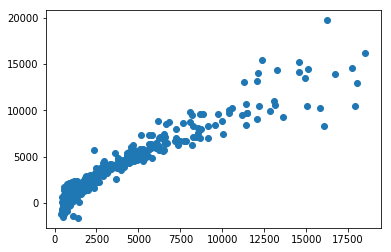

In [29]:
plt.scatter(y_test, predictions);

**Plot shows some curvature as opposed to a straight line**

### Residuals

In [30]:
residuals = y_test - predictions

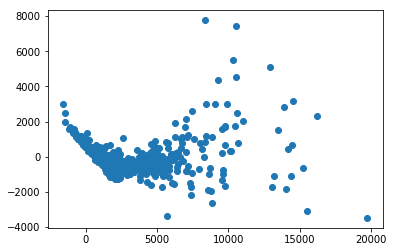

In [31]:
plt.scatter(predictions, residuals);

**Plot shows lower bound due to target distribution (log-normal)**

### Q-Q Plot

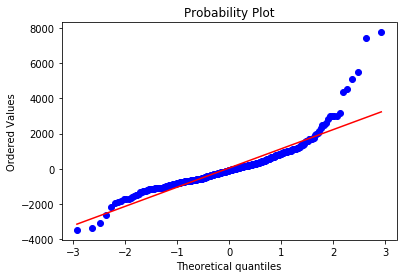

In [32]:
stats.probplot(residuals, dist="norm", plot=plt);

**Points are bowed around red line indicating non-normal distribution of residuals**

# Model Refinement

## Scaled Model
Transform all features to same scale.

In [33]:
# use pipeline to streamline input parameters
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

In [34]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.9195790119382556

In [35]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=10))

0.9161396278390106

R-squared: 0.9007821531459785


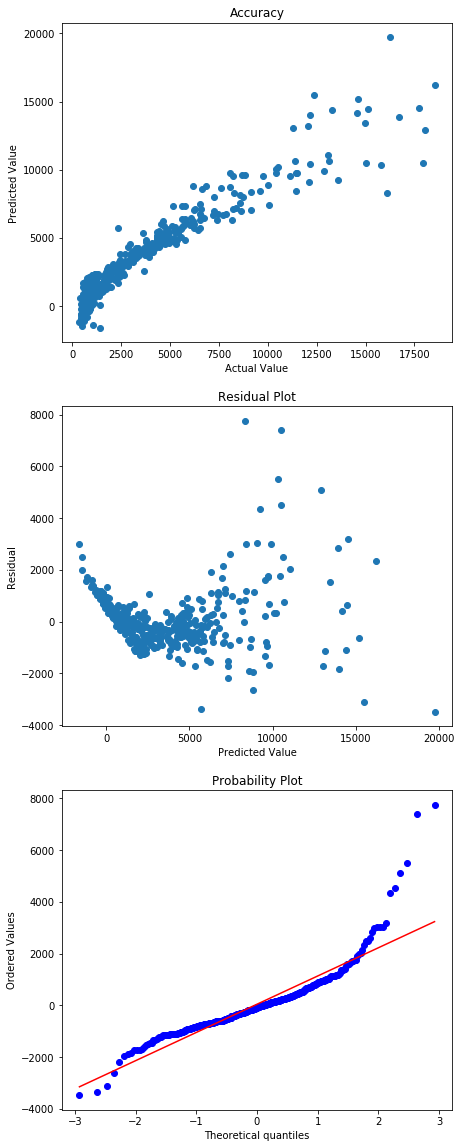

In [36]:
lr_eval(lr_pipe, X_test, y_test)

**No difference in score or plots**

## Log Transform of Feature Variable
Transform feature with apparent log-normal distribution to log scale.

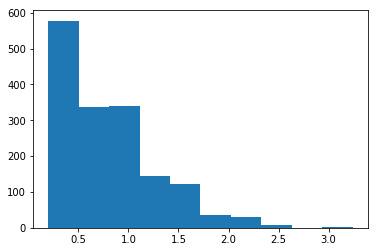

In [37]:
# feature disrtibution
plt.hist(X_train['carat']);

In [38]:
# transform feature to log-scale
X_train_ln = X_train.copy()
X_train_ln['carat'] = X_train_ln['carat'].apply(np.log)
X_test_ln = X_test.copy()
X_test_ln['carat'] = X_test_ln['carat'].apply(np.log)

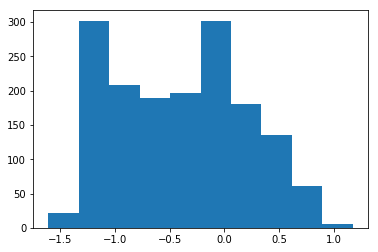

In [39]:
# transformed feature distribution
plt.hist(X_train_ln['carat']);

### Model

In [40]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

In [41]:
lr_pipe.fit(X_train_ln, y_train)
lr_pipe.score(X_train_ln, y_train)

0.916185444901279

In [42]:
np.mean(cross_val_score(lr_pipe, X_train_ln, y_train, cv=10))

0.9135441745861097

R-squared: 0.8430393144286696


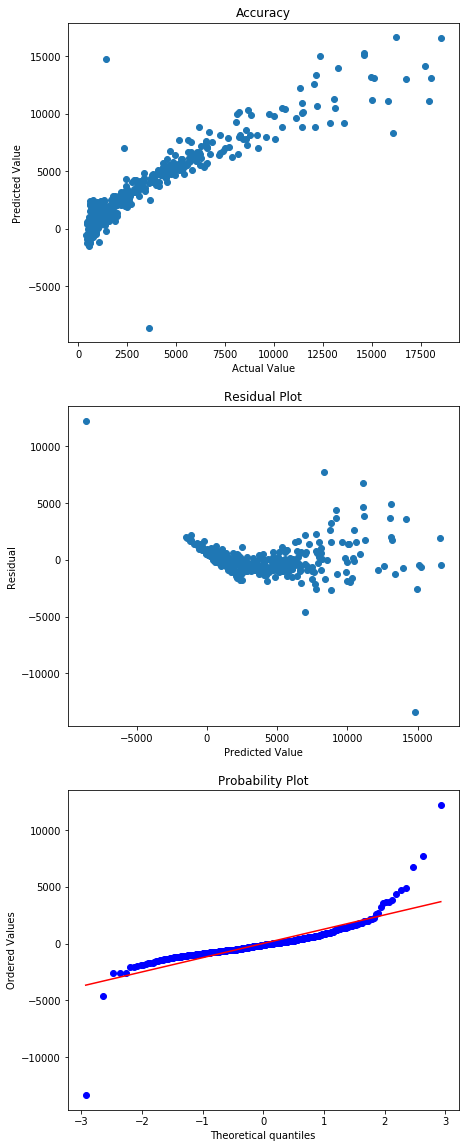

In [43]:
lr_eval(lr_pipe, X_test_ln, y_test)

**Test accuracy is lower than original model.  
Residual plot shows hard lower bound.  
Q-Q plot shows bowing but is improved from original model.**

## Log Transform of Target Variable
Transform target variable with apparent log-normal distribution to log scale.

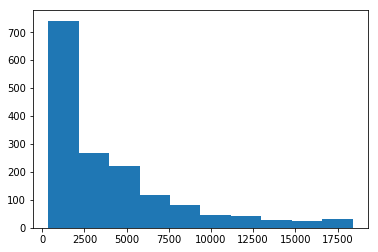

In [44]:
# target distribution
plt.hist(y_train);

In [45]:
# transform target to log-scale
y_train_ln = np.log(y_train)
y_test_ln = np.log(y_test)

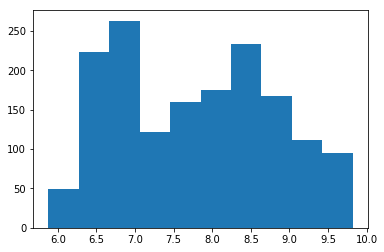

In [46]:
# transformed distribution
plt.hist(y_train_ln);

### Model

In [47]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

In [48]:
lr_pipe.fit(X_train, y_train_ln)
lr_pipe.score(X_train, y_train_ln)

0.9803326535300955

In [49]:
np.mean(cross_val_score(lr_pipe, X_train, y_train_ln, cv=10))

0.9798274930901935

R-squared: 0.9716880458623884


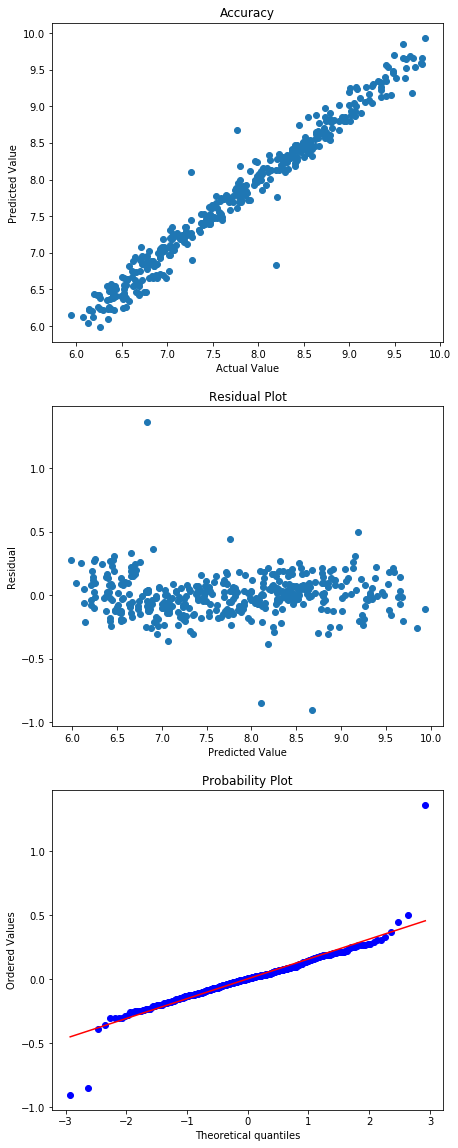

In [50]:
lr_eval(lr_pipe, X_test, y_test_ln)

**Test score shows significant improvement compared with original model.  
Plots show significant improvement of model fit.**

## Select Best Features
Select optimal features for model performance.

In [51]:
# set initial k value
k_0 = 1
# input score method and number of features for selector
feat_selector = feature_selection.SelectKBest(score_func=feature_selection.f_regression, k=k_0)

In [52]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('kbest', feat_selector),
    ('model', LinearRegression())
])

In [53]:
lr_pipe.fit(X_train, y_train)
# score using initial k features
max_test_score = lr_pipe.score(X_test, y_test)
best_k = k_0

# input range for number of features
k_range = range(1, len(X.columns)+1)
train_scores = []
test_scores = []

# iterate through different number of features
for k in k_range:
    
    # input k value into feature selector within pipeline
    lr_pipe.set_params(kbest__k=k)
    # run cross validated model on pipeline
    cv_mod = cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True)
    # record score for cv training set
    train_scores.append(np.mean(cv_mod['train_score']))
    # record score for cv test set
    test_scores.append(np.mean(cv_mod['test_score']))
    
    # check if current cv test score > than current highest
    if np.mean(cv_mod['test_score']) > max_test_score:
        # update best test score
        max_test_score = np.mean(cv_mod['test_score'])
        # update best k value
        best_k = k

Optimal No. Features: 8


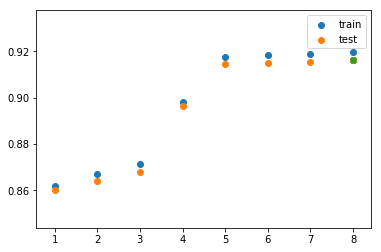

In [54]:
print('Optimal No. Features:', best_k)
plt.scatter(k_range, train_scores, label='train')
plt.scatter(k_range, test_scores, label='test')
plt.scatter(best_k, max_test_score, marker='X')
plt.xlabel('Number of Features')
plt.ylabel('R-squared Score')
plt.legend();

**Using all features gives best performance**

### Model

In [55]:
lr_pipe.set_params(kbest__k=best_k)
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.9195790119382556

In [56]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=10))

0.9161396278390106

R-squared: 0.9007821531459785


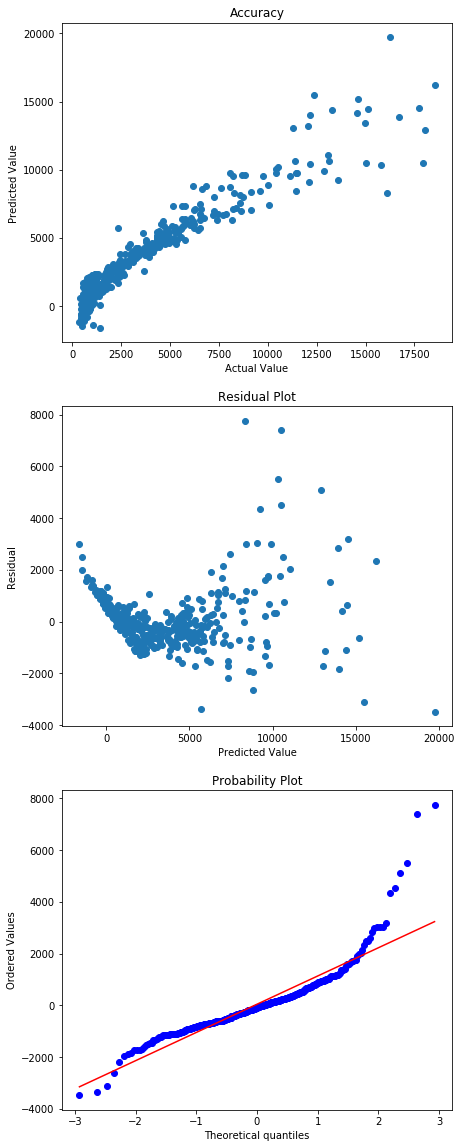

In [57]:
lr_eval(lr_pipe, X_test, y_test)

**Same model as before: No difference in score or plots**

### Feature Interpretation

In [58]:
# list of optimal feature labels
X.columns[lr_pipe.named_steps['kbest'].get_support()]

Index(['carat', 'depth', 'table', 'x', 'y', 'cut', 'color', 'clarity'], dtype='object')

In [59]:
# score of each feature
lr_pipe.named_steps['kbest'].scores_

array([9.96916491e+03, 5.91962432e+00, 2.15686152e+01, 6.19407796e+03,
       6.37818933e+03, 9.93930737e-01, 4.86545354e+01, 5.83990279e+01])

In [60]:
pd.DataFrame(lr_pipe.named_steps['kbest'].scores_, index=X.columns, columns=['Feature Score'])

,Feature Score
carat,9969.164910
depth,5.919624
table,21.568615
x,6194.077965
y,6378.189331
cut,0.993931
color,48.654535
clarity,58.399028


## Polynomial Transformation of Feature Variables
Transform feature data to polynomial features so that it is better able to fit the training data.

In [61]:
# input initial degree
degree_0 = 2

In [62]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=degree_0)),
    ('model', LinearRegression())
])

In [63]:
lr_pipe.fit(X_train, y_train)
# score using initial degree value
max_test_score = lr_pipe.score(X_test, y_test)
best_degree = lr_pipe.named_steps['poly'].degree

# input range for degree values
deg_range = range(2, 5)
train_scores = []
test_scores = []

# iterate through alpha values
for degree in deg_range:
    
    # input current degeree value into model within pipeline
    lr_pipe.set_params(poly__degree=degree)
    # run cross validated model on pipeline
    cv_mod = cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True)
    # record score for cv training set
    train_scores.append(np.mean(cv_mod['train_score']))
    # record score for dv test set
    test_scores.append(np.mean(cv_mod['test_score']))
    
    # check if current cv test score is > current highest
    if np.mean(cv_mod['test_score']) > max_test_score:
        # update best test score
        max_test_score = np.mean(cv_mod['test_score'])
        # update best degree value
        best_degree = degree

Optimal Polynomial Degree: 2


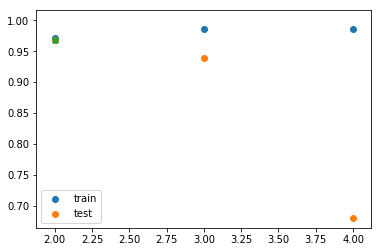

In [64]:
print('Optimal Polynomial Degree:', best_degree)
plt.scatter(deg_range, train_scores, label='train')
plt.scatter(deg_range, test_scores, label='test')
plt.scatter(best_degree, max_test_score, marker='X')
plt.xlabel('Degree of Polynomial')
plt.ylabel('R-squared Score')
plt.legend();

In [65]:
lr_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('model', LinearRegression())
])

In [66]:
lr_pipe.fit(X_train, y_train)
lr_pipe.score(X_train, y_train)

0.9726893091574437

In [67]:
np.mean(cross_val_score(lr_pipe, X_train, y_train, cv=10))

0.968029802286505

R-squared: 0.9515240445045924


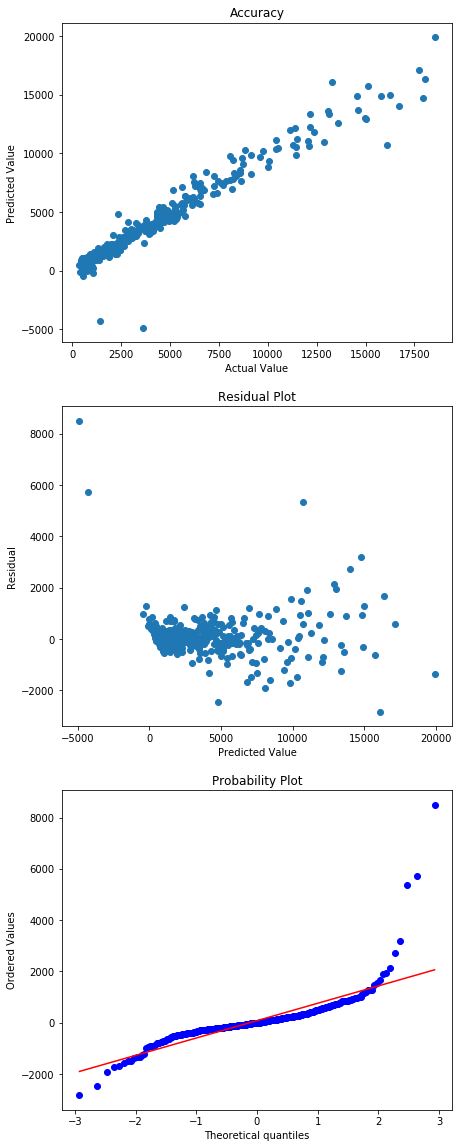

In [68]:
lr_eval(lr_pipe, X_test, y_test)

**Non-normal distribution of residuals.  
Still bowing in Q-Q plot.**

# Final Model
Combine polynomial features and feature and target transformed to log scale for final model.

In [69]:
# parameters for pipeline input
degree = 2
alpha_range = np.linspace(0.001, 10, 10)

In [70]:
lr_reg_pipe = Pipeline([
    ('scaler', MinMaxScaler()),
    ('poly', PolynomialFeatures(degree=degree)),
    ('model', linear_model.RidgeCV(alphas=alpha_range, cv=10, scoring='r2'))
])

In [71]:
lr_reg_pipe.fit(X_train_ln, y_train_ln)
lr_reg_pipe.score(X_train_ln, y_train_ln)

0.9882903432249825

R-squared: 0.9777350480947995


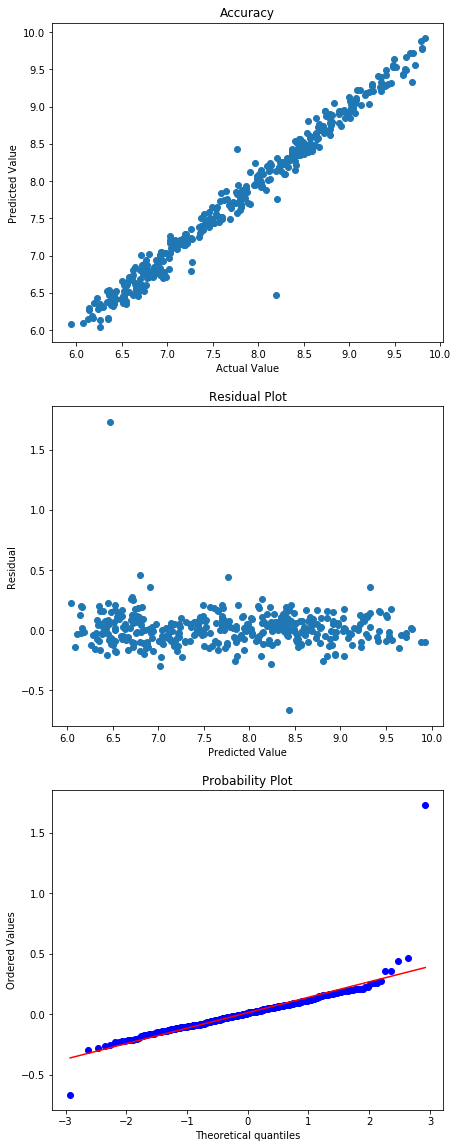

In [72]:
lr_eval(lr_reg_pipe, X_test_ln, y_test_ln)

**High test accuracy.  
Normally distributed residuals.  
Mostly aligned Q-Q plot. Values at tails veer off.**

# Model Interpretation

## Coefficients

In [73]:
# output feature labels for polynomial-based model
feature_labels = lr_reg_pipe.named_steps['poly'].get_feature_names(X.columns)

In [74]:
# model coefficients for each feature
coefs = lr_reg_pipe.named_steps['model'].coef_

In [75]:
# pair feature labels with model coefficients
feat_imp = list(zip(feature_labels, coefs))
feat_imp

[('1', 0.0),
 ('carat', 0.40584998252801086),
 ('depth', 1.8427925236380407),
 ('table', 1.547658005695484),
 ('x', 6.399802925909035),
 ('y', -1.8327457368160909),
 ('cut', 0.18311463838319253),
 ('color', 0.5318722945693578),
 ('clarity', 1.236997827156802),
 ('carat^2', 4.846945964330674),
 ('carat depth', 0.6196704041107363),
 ('carat table', -0.8022433326047818),
 ('carat x', -6.780083742005809),
 ('carat y', 6.73013636594788),
 ('carat cut', 0.22151696333023482),
 ('carat color', 0.11527260122410332),
 ('carat clarity', -0.3471238639961861),
 ('depth^2', -0.9841771089839855),
 ('depth table', -0.7855174701138038),
 ('depth x', 0.7335151622674282),
 ('depth y', -2.516087738011407),
 ('depth cut', -0.06797778683891857),
 ('depth color', -0.14883475852912204),
 ('depth clarity', -0.27337191102104114),
 ('table^2', -0.4864498519665996),
 ('table x', 2.6928958080147),
 ('table y', -2.6916312123173998),
 ('table cut', -0.19623697630176723),
 ('table color', -0.18207568373715394),
 ('ta

In [76]:
# sort features by coefficient absolute value and return only top 10
feat_imp = sorted(feat_imp, key=lambda pair: abs(pair[1]), reverse=True)[:10]
feat_imp

[('x^2', -9.215398425618313),
 ('carat x', -6.780083742005809),
 ('carat y', 6.73013636594788),
 ('x', 6.399802925909035),
 ('x clarity', 6.365454596379561),
 ('y^2', 5.815943664361713),
 ('y clarity', -5.771099109613663),
 ('carat^2', 4.846945964330674),
 ('y cut', -4.017788141637659),
 ('x cut', 3.6959702950007225)]

In [77]:
# return top 10 feature labels
feat_labels = list(zip(*feat_imp))[0]

In [78]:
# return top 10 feature coefficients
feat_coefs = list(zip(*feat_imp))[1]

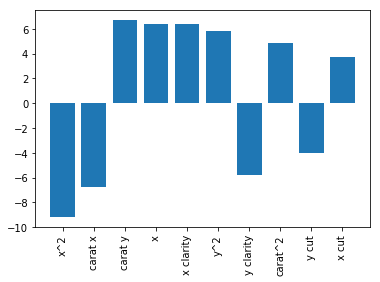

In [79]:
# plot top 10 features vs coefficient values
plt.bar(feat_labels, feat_coefs)
plt.xticks(rotation='vertical');

## Predictions

In [80]:
# maximum price
y_test_max = y_test[y_test == y_test.max()]

In [81]:
# minimum price
y_test_min = y_test[y_test == y_test.min()]

In [82]:
# prices near median
y_test_mid = y_test[(y_test < (y_test.median()+20)) & (y_test > (y_test.median()-20))]

In [83]:
y_test_sample = pd.concat([y_test_max, y_test_min, y_test_mid])

In [84]:
X_test_sample = X_test_ln.loc[y_test_sample.index, :]
X_test_sample

,carat,depth,table,x,y,cut,color,clarity
27628,0.760806,60.3,60.0,8.31,8.43,2,6,1
38253,-1.171183,62.5,60.0,4.31,4.36,3,0,3
51890,-0.248461,57.5,63.0,6.13,6.05,1,6,1
51718,-0.356675,57.2,63.0,5.84,5.87,1,4,2
51846,-0.356675,63.8,60.0,5.63,5.60,1,4,2
51586,-0.314711,60.3,58.0,5.87,5.83,3,1,4


In [85]:
# output model predictions (output in log-scale)
lr_reg_pipe.predict(X_test_sample)

array([9.92406705, 6.08419518, 7.75552178, 7.69959964, 7.70289724,
       7.84562569])

In [86]:
# transform model predictions back to normal scale
predictions = np.exp(lr_reg_pipe.predict(X_test_sample))
predictions

array([20415.85431715,   438.86646176,  2334.42709475,  2207.46403564,
        2214.75538553,  2554.53551824])

In [87]:
np.set_printoptions(suppress=True)

In [88]:
np.round(predictions, 0)

array([20416.,   439.,  2334.,  2207.,  2215.,  2555.])

In [89]:
y_test_sample.values

array([18526,   380,  2430,  2401,  2423,  2393])

In [90]:
abs(y_test_sample.values - predictions)

array([1889.85431715,   58.86646176,   95.57290525,  193.53596436,
        208.24461447,  161.53551824])

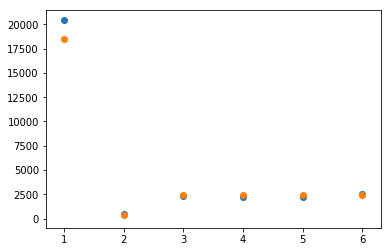

In [91]:
plt.scatter(range(1, len(X_test_sample)+1), predictions)
plt.scatter(range(1, len(y_test_sample)+1), y_test_sample);